   water level                Date
0     0.000000 2024-01-01 00:00:00
1     0.121757 2024-01-01 01:00:00
2     0.243514 2024-01-01 02:00:00
3     0.365271 2024-01-01 03:00:00
4     0.487028 2024-01-01 04:00:00
(8640, 2)


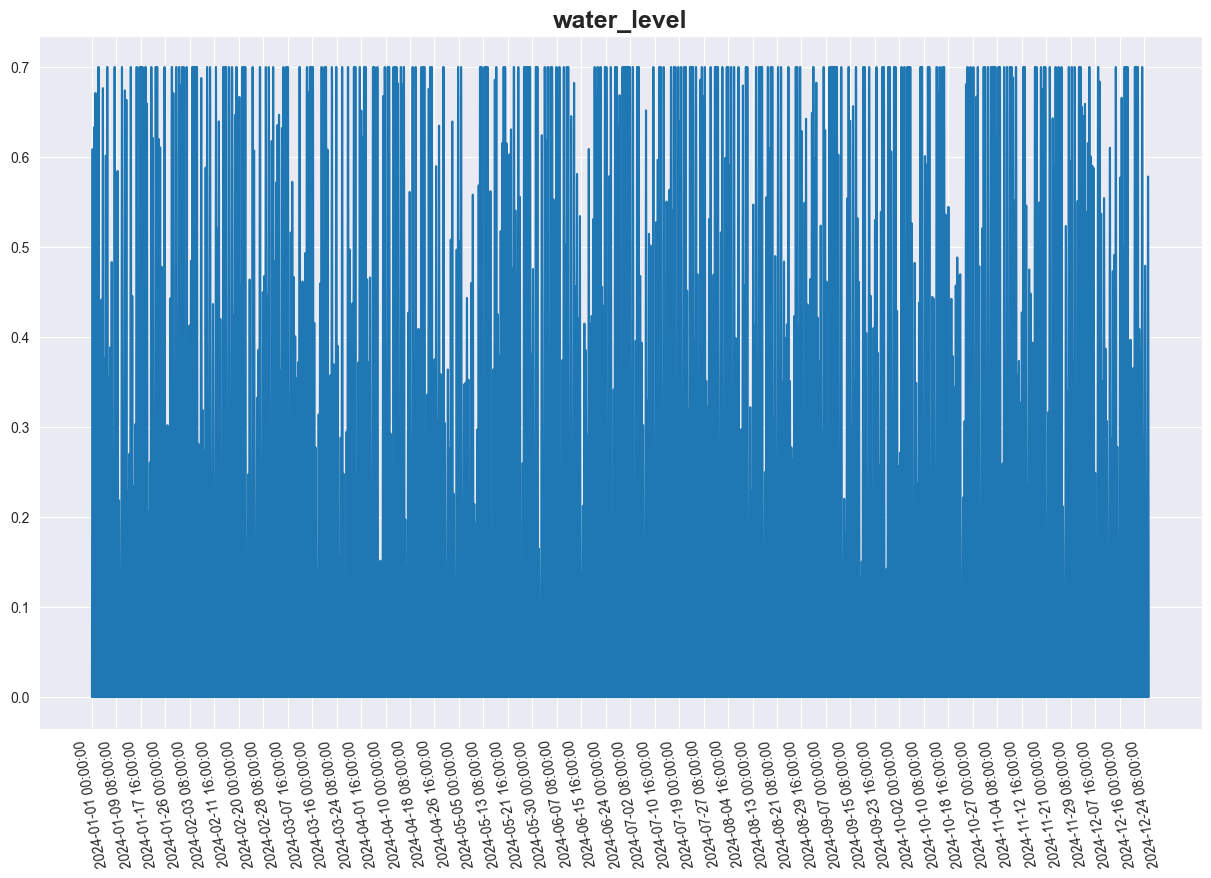

In [176]:
import numpy as np               # 导入NumPy库，用于科学计算
import pandas as pd              # 导入Pandas库，用于数据操作和分析
import matplotlib.pyplot as plt  # 导入Matplotlib库中的pyplot模块，用于绘图
import seaborn as sns            # 导入Seaborn库，用于增强Matplotlib的绘图功能

# 读取数据
filepath = 'simulated_data_k=real_test.csv'
data = pd.read_csv(filepath)  ##从CSV文件读取数据并存储在data变量中。
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M')  ##将Date列转换为datetime格式，便于处理时间序列数据。
print(data.head())  ##打印数据的前几行以查看内容。
print(data.shape)  ##打印数据的形状（行数和列数）。

# 可视化收盘价
sns.set_style("darkgrid")  ##设置Seaborn的绘图风格为“darkgrid”。
plt.figure(figsize=(15, 9))  ##创建一个新的图形，设置大小为15x9英寸。
plt.plot(data[['water level']])  ##绘制water level列的数据。
plt.xticks(range(0, data.shape[0], 200), data['Date'].loc[::200], rotation=100)
##设置x轴的刻度，以每200个数据点显示一个日期，并旋转标签以便于阅读。
plt.title("water_level", fontsize=18, fontweight='bold')  ##设置图表标题。
plt.show()  ##显示图形。

## 1.特征工程

In [177]:
# 选取Close作为特征
price = data[['water level']]              # 从数据集中选取收盘价（Close）列作为特征
print(price.info())                  # 打印选取特征后的数据框信息

from sklearn.preprocessing import MinMaxScaler  # 从sklearn库中导入MinMaxScaler进行数据缩放
# 进行数据缩放，将数据缩放到-1和1之间
scaler = MinMaxScaler(feature_range=(-1, 1))    # 创建MinMaxScaler对象，设置缩放范围为-1到1
price['water level'] = scaler.fit_transform(price['water level'].values.reshape(-1, 1))
                                               # 对收盘价数据进行缩放，并将结果更新到price数据框中
                                               # 先将收盘价数据转换为二维数组，再进行缩放

print(price['water level'].shape)                    # 打印缩放后的数据形状


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   water level  8640 non-null   float64
dtypes: float64(1)
memory usage: 67.6 KB
None
(8640,)


/var/folders/8s/y_3gplhx05z8pjf175k9lqgr0000gn/T/ipykernel_25020/3347666992.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2.数据集制作

In [178]:
# 今天的收盘价预测明天的收盘价
# lookback表示观察的跨度
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    # print(data)

    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (6910, 2, 1)
y_train.shape =  (6910, 1)
x_test.shape =  (1727, 2, 1)
y_test.shape =  (1727, 1)


## 3.模型构建 —— LSTM_KAN

In [179]:
# 注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)
# 3.模型构建 —— LSTM

import torch
import torch.nn as nn
from kan import KAN

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的layers
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
num_epochs = 100


class LSTM_KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_KAN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_dim, output_dim)
        self.kan=KAN(width=[hidden_dim, output_dim])

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.kan(out[:, -1, :])
        return out



model = LSTM_KAN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## 4.模型训练

In [180]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4748321771621704
Epoch  1 MSE:  0.41598644852638245
Epoch  2 MSE:  0.4433719515800476
Epoch  3 MSE:  0.3978896737098694
Epoch  4 MSE:  0.3686617314815521
Epoch  5 MSE:  0.37175896763801575
Epoch  6 MSE:  0.36274033784866333
Epoch  7 MSE:  0.3262568414211273
Epoch  8 MSE:  0.28755655884742737
Epoch  9 MSE:  0.2683744430541992
Epoch  10 MSE:  0.2542719542980194
Epoch  11 MSE:  0.22210757434368134
Epoch  12 MSE:  0.18977850675582886
Epoch  13 MSE:  0.1929643154144287
Epoch  14 MSE:  0.2176876664161682
Epoch  15 MSE:  0.22249431908130646
Epoch  16 MSE:  0.2166963517665863
Epoch  17 MSE:  0.20588481426239014
Epoch  18 MSE:  0.1883014291524887
Epoch  19 MSE:  0.17372630536556244
Epoch  20 MSE:  0.16957783699035645
Epoch  21 MSE:  0.17201316356658936
Epoch  22 MSE:  0.17432431876659393
Epoch  23 MSE:  0.17445190250873566
Epoch  24 MSE:  0.1732971966266632
Epoch  25 MSE:  0.170757457613945
Epoch  26 MSE:  0.16529996693134308
Epoch  27 MSE:  0.15645796060562134
Epoch  28 MSE:  

## 5.模型结果可视化

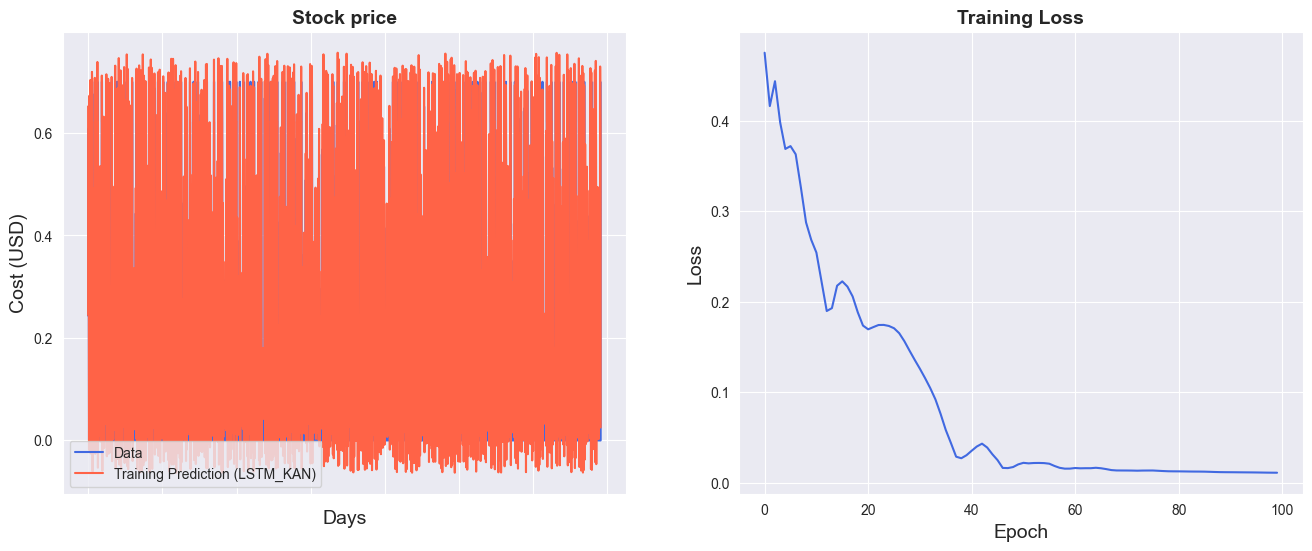

In [181]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM_KAN)", color='tomato')
# print(predict.index)
# print(predict[0])


ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

## 6.模型验证

In [182]:
# print(x_test[-1])
import math, time
from sklearn.metrics import mean_squared_error,r2_score

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


trainr2Score = r2_score(y_train[:,0], y_train_pred[:,0])
print('Train Score: %.2f R2' % (trainr2Score))
testr2Score = r2_score(y_test[:,0], y_test_pred[:,0])
print('Test Score: %.2f R2' % (testr2Score))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE
Train Score: 0.97 R2
Test Score: 0.97 R2
Train Score: 0.00139 MSE
Test Score: 0.00136 MSE
Train Score: 0.97 NSE
Test Score: 0.97 NSE


## 7. 绘制图像

In [183]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM_KAN)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()